## Task Description

The goal of this exercise is to model the relationship between weather observations and the amounts of cyclists in the city of Vienna.

To investigate a potential relationship, we will use two datasets:
 * tri-daily weather reports from 2009 - 2023 of Vienna.
 * daily cyclists in Vienna from 2021 - 2022.

In this exercise, you will 
 * use `pandas` to read, prepare and transform data,
 * use `matplotlib` to visually analyse data,
 * use `scikit-learn` to build prediction models.

The data to be used can be found in the provided paths

To complete this exercise, you will have to:
* prepare the data, which (at minimum) involves the following:
    - load and prepare the data
    - handling missing values
    - handling outliers
    - temporal alignment of the two datasets
* analyse the data:
    - compare descriptive statistics
    - visually investigate the raw data to gain an understanding of the data identify patterns, outliers etc.,
 

**As this is a practice notebook, we are showing you all hidden tests, during the exams they will not be visible**


**Keep in mind that the exam also tests different aspects of Data Processing then this notebook does, and contains more programming and multiple choice questions**

In [193]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime
import pickle
import typing


In [194]:
data_path = os.path.join(os.environ["HOME"], "shared", "194.192-2025W", "data", "cyclists")
weather_data_path = os.path.join(data_path, 'weather')
cyclists_data_path = os.path.join(data_path, 'cyclists')

## Data Loading

As a first step, implement the method `load_weather_data()`, which should read all individual (yearly) datasets from the csv files in `data/weather/` into a single `pd.DataFrame` and return it. 

- make sure that you load all the data (2009-2023, 15 years)
- split the tri-daily and daily data (tri-daily data has _7h, _14h, and _19h suffixes for column headers), and convert the tri-daily data from a wide to a long format (use pandas' [wide_to_long](https://pandas.pydata.org/docs/reference/api/pandas.wide_to_long.html) or [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html#pandas.melt) functions). Introduce a new `hours` column which's values should be taken from the column suffixes.
- make sure all columns are appropriately typed (numeric values -> float, countables, i.e. days -> int, etc.)! Especially the `date` column! See datetime and [`pandas.Timestamp`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html)!
- from the `date` column create `year`, `month`, `day` columns. Use Pandas built-in datetime handling features.
- from the wide to long transform, you should have an `hour` column with the 7, 14, or 19 hours values.
- create a `MultiIndex` from the date columns with the following hierarchy: `year` - `month` - `day` - `hour` (make sure to label them accordingly)

**Hints:**
 
 - LOOK at the data in the original files
 - It is advisable not to append each data set individually, but to read each data frame, store it into a list and  combine them once at the end.
 - Note that for the `precip` data column you will get an unexpected (object) datatype. For this task it is ok to leave it like that, it is due to special values, see next chapters!
 - You will find similar names, in the disruption column, you are free to combine them to reduce the number of different disruptions.
 - Your resulting data frame should look as follows, with temperature in Celsius, air pressure in hecto Pascal, skyCover on a scale from 1-10, humidity in percent, windDir in compass directions, windBeauf in Beaufort and precip in millimeters.: ![alt text](img.png "Dataframe")

In [206]:
def load_weather_data(weather_data_path:str) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Split the tri-daily data from the daily data.
    For the tri-daily data create a new hour column using the indicated hour in the column names.
    Add a hierarchical index (year, month, day, hour).
    For the daily-only data also add a hierarchical index (year, month, day).
    
    Parameters
    --------
    weather_data_path: path to directory containing weather data CSV files
    
    Returns
    --------
    weather_data: data frame containing the tri-daily (hours) weather data
    weather_data_daily: data frame containing the daily weather data (e.g. precip, precipType, etc.)
    """

    # YOUR CODE HERE
    dirs = os.listdir(weather_data_path)

    dfs = []
    for dir in dirs:
        if dir.endswith('.csv'):
            df = pd.read_csv(os.path.join(weather_data_path, dir), sep = ';')
            if dir.endswith('2023.csv'):
                df['temp_7h'] = (df['temp_7h'] - 32) / 1.8
                df['temp_14h'] = (df['temp_14h'] - 32) / 1.8
                df['temp_19h'] = (df['temp_19h'] - 32) / 1.8
            
            dfs.append(df)


    df = pd.concat(dfs, ignore_index = True)

    df['date'] = pd.to_datetime(df['date'], format = '%d.%m.%Y')
    
    df['year'] = df['date'].dt.year  
    df['month'] = df['date'].dt.month  
    df['day'] = df['date'].dt.day 

    df = pd.wide_to_long(df, stubnames = ['airPressure', 'skyCover', 'temp','windBeauf','windDir','hum'], i = 'date', j = 'hour', sep='_', suffix='\\d+h').reset_index()

    df['hour'] = df['hour'].str.replace('h', '')


    cols = ['year', 'month', 'day', 'hour', 'airPressure','skyCover','temp','windBeauf','hum']
    df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')

    # df['date'] = pd.to_datetime(df['date'], unit = 'ns')

    weather_data = df.filter(items = ['date', 'year', 'month','day','airPressure','skyCover','temp','windBeauf','windDir','hum','hour'])
    weather_data_daily = df.filter(items = ['date', 'year', 'month','day','precip','precipType'])

    weather_data = weather_data.set_index(keys = ['year','month','day','hour'])
    weather_data_daily = weather_data_daily.set_index(keys = ['year','month','day'])
    
    return weather_data, weather_data_daily

In [207]:
# DO NOT MODIFY OR COPY THIS CELL!! 
weather_data, daily_weather_data = load_weather_data(weather_data_path)
# print first couple of rows:
print('hourly weather data:')
display(weather_data.head())
print('\ndaily weather data:')
display(daily_weather_data.head())

hourly weather data:


/tmp/ipykernel_181/924315214.py:48: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')


date  airPressure  skyCover  temp  windBeauf  \
year month day hour                                                      
2010 1     1   7    2010-01-01        966.4        10   4.1          1   
           2   7    2010-01-02        977.6        10   1.8          3   
           3   7    2010-01-03        992.6         4  -2.7          4   
           4   7    2010-01-04        993.6         9  -1.8          2   
           5   7    2010-01-05        986.8        10  -3.0          2   

                    windDir  hum  
year month day hour               
2010 1     1   7          W   94  
           2   7          W   92  
           3   7          W   69  
           4   7          S   79  
           5   7         SE   86


daily weather data:


date precip     precipType
year month day                                 
2010 1     1   2010-01-01    3.6           rain
           2   2010-01-02    3.9  rain and snow
           3   2010-01-03    0.4           snow
           4   2010-01-04      0            NaN
           5   2010-01-05    6.2           snow

In [208]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# TESTS: dimensions should be like this:
assert weather_data.shape[0] == 16434
assert weather_data.shape[1] >= 7

In [209]:
#### TESTS
#check for Fahrenheit Conversion
assert weather_data[weather_data['date']>='2023-01-01']['temp'].min() < 0 

In [210]:
#### TESTS
assert pd.date_range(start = '2009-01-01', end = '2023-12-31').difference(weather_data.date).empty
assert weather_data.set_index('date').index.difference(pd.date_range(start = '2009-01-01', end = '2023-12-31', freq='1D')).empty


In [211]:
### TESTS
# check if all dates are present
index_dtypes = weather_data.index.dtypes

assert pd.api.types.is_integer_dtype(index_dtypes.iloc[0])
assert pd.api.types.is_integer_dtype(index_dtypes.iloc[1])
assert pd.api.types.is_integer_dtype(index_dtypes.iloc[2])
assert pd.api.types.is_integer_dtype(index_dtypes.iloc[3])

assert pd.api.types.is_datetime64_any_dtype(weather_data['date'].dtype)
assert pd.api.types.is_float_dtype(weather_data['temp'].dtype)
assert pd.api.types.is_float_dtype(weather_data['airPressure'].dtype)
assert pd.api.types.is_integer_dtype(weather_data['hum'].dtype)
assert pd.api.types.is_integer_dtype(weather_data['skyCover'].dtype)
assert pd.api.types.is_integer_dtype(weather_data['windBeauf'].dtype)
assert pd.api.types.is_string_dtype(weather_data['windDir'].dtype)

assert pd.api.types.is_string_dtype(daily_weather_data['precip'].dtype)
assert pd.api.types.is_string_dtype(daily_weather_data['precipType'].dtype)

In which month was the average temperature the lowest?
- Implement the function below to find the answer!
- Find the respective entry/entries using pandas!!

In [212]:
def get_lowest_average_temp(data_frame:pd.DataFrame):
    year = 0
    month = 0

    df = data_frame.copy().reset_index()

    df = df.groupby(by = ['year', 'month'])['temp'].mean()

    year, month = df.idxmin()

    return year, month

In [213]:
# DO NOT MODIFY OR COPY THIS CELL!!
low_num_year, low_num_month = get_lowest_average_temp(weather_data)
print(f"Month {low_num_month}, of year {low_num_year} has the lowest average temperature!")

Month 1, of year 2017 has the lowest average temperature!


In [214]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!
### Tests
assert low_num_year == 2017
assert low_num_month == 1

### Task: Implement the `load_cycling_data` Method

In this exercise, you will write a function to **load and prepare cycling traffic data from Vienna**.  
The goal is to read the dataset, enrich it with useful time-related information, and return a well-structured DataFrame.

#### Steps you should implement:
1. **Load the dataset**  
   - Read the CSV file `cyclists.csv` from the provided `cyclist_data_path`.  

3. **Add weekday information**  
   - Create a new column `day_of_week` that contains the weekday name (e.g., *Monday*, *Tuesday*).

4. **Reorganize the DataFrame index**  
   - Sort the data by `year`, `month`, and `day`.  
   - Set these columns as a **multi-index** (`year`, `month`, `day`) for easier time-based access.

5. **Return the processed data**  
   - The function should return the cleaned and enriched DataFrame with cycling traffic data.


In [215]:
def load_cycling_data() -> pd.DataFrame:

    # YOUR CODE HERE
    df = pd.read_csv(os.path.join(cyclists_data_path, 'cyclists.csv'))

    print(df)

    df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

    df['day_of_week'] = df['date'].dt.day_name()

    df['year'] = df['date'].dt.year  
    df['month'] = df['date'].dt.month  
    df['day'] = df['date'].dt.day 

    df = df.sort_values(by = ['year', 'month', 'day'])
    data = df.set_index(keys = ['year', 'month', 'day'])

    return data

In [216]:
data_cyclists = load_cycling_data()
display(data_cyclists)

           date  number
0    2021-01-01     412
1    2021-01-02     648
2    2021-01-03     707
3    2021-01-04    1006
4    2021-01-05    1198
..          ...     ...
725  2022-12-27    1091
726  2022-12-28    1245
727  2022-12-29    1102
728  2022-12-30    1159
729  2022-12-31     782

[730 rows x 2 columns]


date  number day_of_week
year month day                               
2021 1     1   2021-01-01     412      Friday
           2   2021-01-02     648    Saturday
           3   2021-01-03     707      Sunday
           4   2021-01-04    1006      Monday
           5   2021-01-05    1198     Tuesday
...                   ...     ...         ...
2022 12    27  2022-12-27    1091     Tuesday
           28  2022-12-28    1245   Wednesday
           29  2022-12-29    1102    Thursday
           30  2022-12-30    1159      Friday
           31  2022-12-31     782    Saturday

[730 rows x 3 columns]

This method calculates the **average number of cyclists** for a given season and year from the dataset.

- It first ensures the `date` column is in datetime format.  
- Seasons are defined by months:
  - **Spring**: March–May  
  - **Summer**: June–August  
  - **Autumn**: September–November  
  - **Winter**: December (previous year) + January–February (current year)  
- The method filters the DataFrame for the specified `season` and `year`.  
- It then computes the mean of the `number` column (cyclist counts) and returns the rounded result.

In [217]:
def average_cyclists_per_season(df: pd.DataFrame, season: str, year: int) -> int:
    def get_season(row):
        month = row['month']

        if month >= 3 and month <= 5:
            return 'spring'
        elif month >= 6 and month <= 8:
            return 'summer'
        elif month >= 9 and month <= 11:
            return 'autumn'
        else:
            return 'winter'

    df = df.reset_index()
    df['season'] = df.apply(get_season, axis = 1)

    df = df.groupby(by = ['year','season'])['number'].mean()


    print(round(df[year, season]))
    return round(df[year, season])
    

In [218]:
## Test
assert average_cyclists_per_season(data_cyclists, "summer", 2022)==3908

3908


## Data Cleaning
### Temperature outliers
First we want to take a closer look at the temperature values. Check if we can identify some obvious outliers and come up with a strategy to handle/fix them.

In order to do so you will have to:
- Plot the temperature curve over time and a histogram of temperature values to identify possible outliers
- Plot a zoomed in version of individual outliers to get a better understanding what's happening
- Devise a strategy to get rid of outliers

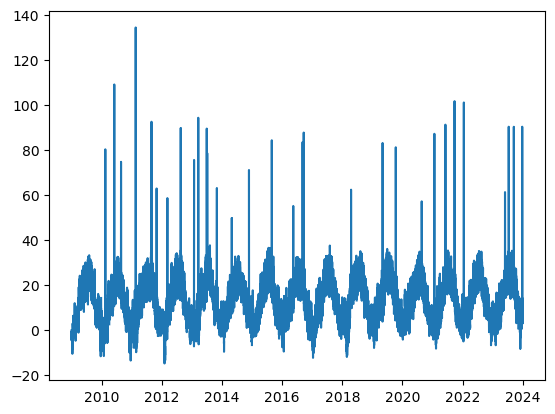

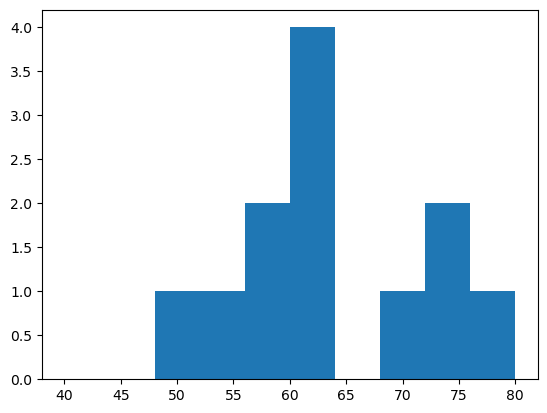

In [219]:
def plot_value_series(df:pd.DataFrame, column:str) -> None:
    """ 
    Plot the values in column in data frame df
    """
    df.plot(kind='line', y=column, figsize=(15,3))

def plot_temp_analysis(df: pd.DataFrame) -> None:
    """
    Create two plots:
    1) Temperature values over time for the whole dataframe
    2) A histogram for temperature values. 
       Choose appropriate bins enabling you to identify outliers!

    Parameters
    --------
    df: data frame containint the temperature values (temp) with potential outlier
    
    """

    # plot
    fig, ax = plt.subplots()
    df = df.sort_values(by = ['date'])
    
    ax.plot(df['date'], df['temp'])
    
    plt.show()

    #plot2
    fig, ax = plt.subplots()
    plt.hist(df['temp'], range = (40,80))
    plt.show()
    

# DO NOT MODIFY OR COPY THIS CELL!!
plot_temp_analysis(weather_data)

#### Remove temperature outliers
Implement the below function using the strategy you defined above to get rid of the temperature outliers

In [220]:
def handle_temp_outliers(noisy_data) -> pd.DataFrame:
    """
    Parameters
    --------
    noisy_data: data frame that contains temperature outliers ('temp' column)

    Returns
    --------
    cleaned_data: data frame with temperature outliers removed/handled
    """
    cleaned_data = noisy_data.copy()

    Q1 = cleaned_data['temp'].quantile(0.25)
    Q3 = cleaned_data['temp'].quantile(0.75)

    IQR = Q3-Q1

    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR

    cleaned_data['temp'] = cleaned_data['temp'].clip(upper = upper, lower = lower)

    return cleaned_data

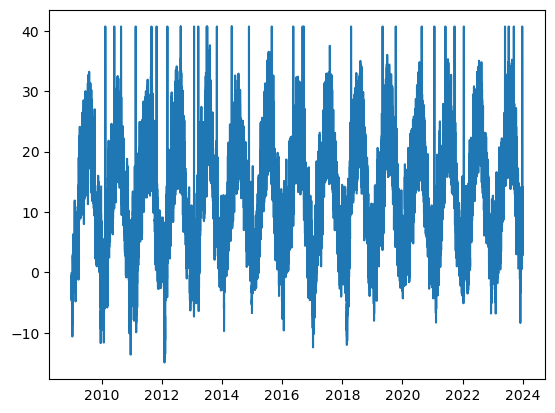

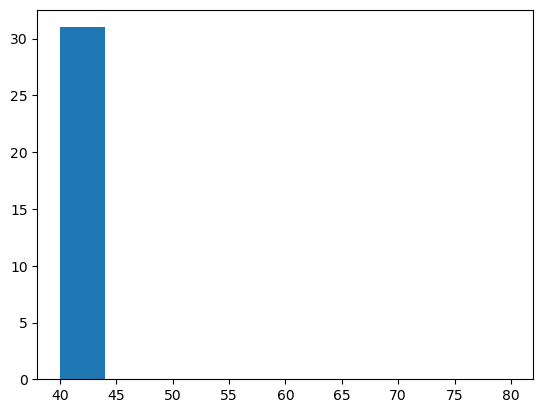

count    16098.000000
mean        12.474382
std          9.092229
min        -14.900000
25%          5.200000
50%         12.200000
75%         19.400000
max         40.700000
Name: temp, dtype: float64


In [221]:
# DO NOT MODIFY OR COPY THIS CELL!!
weather_data_cleaned = handle_temp_outliers(weather_data)
plot_temp_analysis(weather_data_cleaned)
print(weather_data_cleaned['temp'].describe())

#### Data inspection
Check the occurance of the non-numeric values in the precipitation data. You can check the file `data/weather/weather_description_<year>.txt`, which might have additional clues what is going on.

Implement the function below and return a list of the non-numeric values that occur in the `precip` column of `daily_weather_data`. Make sure to only return every unique value once! 

In [236]:
def get_non_numeric_precip_values(df:pd.DataFrame) -> typing.Set[str]:
    """
    Parameters
    --------
    df: data frame that contains non-numeric values in precip column

    Returns
    -------
    non_numeric_values: list of unique non-numeric values. 
    Do not return duplicate values in the list!
    """
    non_numeric_values = set()

    lst = df['precip'].to_list()

    for precip in lst:
        try:
            number = eval(precip)
        except:
            non_numeric_values.add(precip)

    return non_numeric_values

In [237]:
# DO NOT MODIFY OR COPY THIS CELL!!
non_numeric_values = get_non_numeric_precip_values(daily_weather_data)
print(f"\nnon-numeric values values: {non_numeric_values}")


non-numeric values values: {'traces'}


#### Fix non-numeric values
Replace non-numeric values with some appropriate numerical values and convert the column to a more suitable data type.
To get an idea, what appropriate values might be, check the file `data/weather/weather_description_<year>.txt` and the other numeric values in the `precip` column.

In [253]:
def fix_precip_values(df:pd.DataFrame) -> pd.DataFrame:
    """
    Parameters
    --------
    df: data frame that contains non-numeric values in precip column

    Returns
    -------
    ret_df: data frame with fixed precip values
    """
    ret_df = df.copy()

    # YOUR CODE HERE
    ret_df['precip'] = ret_df['precip'].mask(ret_df['precip'] == 'traces', 0.01)

    ret_df['precip'] = ret_df['precip'].astype(float)

    print(ret_df.dtypes)


    return ret_df

In [254]:
daily_weather_data_fixed_precip = fix_precip_values(daily_weather_data)

date          datetime64[ns]
precip               float64
precipType            object
dtype: object


In [255]:
unique_values = pd.unique(daily_weather_data_fixed_precip['precip'].values.ravel())
unique_values = np.sort(unique_values)
print(unique_values[:10])

[0.   0.01 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8 ]


In [256]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
assert pd.api.types.is_float_dtype(daily_weather_data_fixed_precip['precip'].dtype), "precip should now be a float column!!"
assert daily_weather_data_fixed_precip.shape == daily_weather_data.shape, "do not remove or add rows!"

unique_values = pd.unique(daily_weather_data_fixed_precip['precip'].values.ravel())
unique_values = np.sort(unique_values)
print(unique_values[:10])
assert np.isclose(unique_values[0], 0.0), "values for traces should be greater than 0.0mm!"
assert np.isclose(unique_values[2], 0.1), "values for traces should be smaller than 0.1mm!"


[0.   0.01 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8 ]


In [257]:
# DO NOT MODIFY OR COPY THIS CELL!!
def fix_values_daily(data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    complete_data = data.copy()
    complete_data = fix_precip_values(complete_data)
    
    return complete_data

   
def handle_outliers(data):
    """ 
    Parameters
    --------
    data: data frame containing outlier values 
    
    Returns
    --------
    complete_data: data frame not containing any outlier values
    """
    complete_data = data.copy()
    complete_data = handle_temp_outliers(complete_data)
    
    return complete_data

In [258]:
# DO NOT MODIFY OR COPY THIS CELL!!
daily_weather_data_finished = fix_values_daily(daily_weather_data)
weather_data_finished = handle_outliers(weather_data)

date          datetime64[ns]
precip               float64
precipType            object
dtype: object


In [259]:
weather_data_finished

date  airPressure  skyCover  temp  windBeauf  \
year month day hour                                                      
2010 1     1   7    2010-01-01        966.4        10   4.1          1   
           2   7    2010-01-02        977.6        10   1.8          3   
           3   7    2010-01-03        992.6         4  -2.7          4   
           4   7    2010-01-04        993.6         9  -1.8          2   
           5   7    2010-01-05        986.8        10  -3.0          2   
...                        ...          ...       ...   ...        ...   
2015 12    27  19   2015-12-27       1007.0         8   0.6          1   
           28  19   2015-12-28       1005.5         3   2.7          1   
           29  19   2015-12-29       1007.3        10   1.8          1   
           30  19   2015-12-30       1010.5         1  -0.2          3   
           31  19   2015-12-31       1004.0         9  -2.5          2   

                    windDir  hum  
year month day hour               
2010 1     1   7          W   94  
           2   7          W   92  
           3   7          W   69  
           4   7          S   79  
           5   7         SE   86  
...                     ...  ...  
2015 12    27  19        SE   98  
           28  19        SW   93  
           29  19        SE   93  
           30  19        SE   53  
           31  19        SE   82  

[16434 rows x 7 columns]

## Aggregate values

Aggregate the observations on a daily basis. Return a data frame with a hierarchical index (levels `year`, `month` and `day`) and the following daily aggregations as columns:

- `temp_dailyMin`: minimum of `temp`
- `temp_dailyMax`: max of `temp`
- `temp_dailyMean`: mean of `temp`
- `temp_dailyMedian`: median of `temp`

- `hum_dailyMin`: min of `hum`
- `hum_dailyMax`: max of `hum`
- `hum_dailyMean`: mean of `hum`

- `wind_dailyMean`: mean of `windBeauf`
- `wind_dailyMax`: max of `windBeauf`
- `wind_dailyMin`: min of `windBeauf`

Additionally merge the precipitation values from the `daily_weather_data` dataframe also into the newly created dataframe.


In [294]:
def aggregate_daily(hourly_data, daily_data):

    hourly_data_agg = pd.DataFrame()
    
    hourly_data_agg['temp_dailyMin'] = hourly_data.groupby(by = ['year','month','day'])['temp'].min()
    hourly_data_agg['temp_dailyMax'] = hourly_data.groupby(by = ['year','month','day'])['temp'].max()
    hourly_data_agg['temp_dailyMean'] = hourly_data.groupby(by = ['year','month','day'])['temp'].mean()
    hourly_data_agg['temp_dailyMedian'] = hourly_data.groupby(by = ['year','month','day'])['temp'].median()

    hourly_data_agg['hum_dailyMin'] = hourly_data.groupby(by = ['year','month','day'])['hum'].min()
    hourly_data_agg['hum_dailyMax'] = hourly_data.groupby(by = ['year','month','day'])['hum'].max()
    hourly_data_agg['hum_dailyMean'] = hourly_data.groupby(by = ['year','month','day'])['hum'].mean()

    hourly_data_agg['wind_dailyMean'] = hourly_data.groupby(by = ['year','month','day'])['windBeauf'].mean()
    hourly_data_agg['wind_dailyMax'] = hourly_data.groupby(by = ['year','month','day'])['windBeauf'].max()
    hourly_data_agg['wind_dailyMin'] = hourly_data.groupby(by = ['year','month','day'])['windBeauf'].min()

    hourly_data_agg = hourly_data_agg.reset_index()

    hourly_data_agg = hourly_data_agg.merge(daily_data['precip'], on = ['year','month', 'day']).reset_index()

    hourly_data_agg = hourly_data_agg.set_index(keys = ['year','month', 'day'])
    
    return hourly_data_agg

In [295]:
agg_daily_data = aggregate_daily(weather_data_finished, daily_weather_data_finished)

In [296]:
agg_daily_data

index  temp_dailyMin  temp_dailyMax  temp_dailyMean  \
year month day                                                        
2009 1     1        0           -4.5           -0.1       -2.133333   
           1        1           -4.5           -0.1       -2.133333   
           1        2           -4.5           -0.1       -2.133333   
           2        3           -3.0           -1.3       -2.000000   
           2        4           -3.0           -1.3       -2.000000   
...               ...            ...            ...             ...   
2023 12    30   16429            7.1           11.9        9.933333   
           30   16430            7.1           11.9        9.933333   
           31   16431            2.9            3.7        3.266667   
           31   16432            2.9            3.7        3.266667   
           31   16433            2.9            3.7        3.266667   

                temp_dailyMedian  hum_dailyMin  hum_dailyMax  hum_dailyMean  \
year month day                                                                
2009 1     1                -1.8            71            79      74.000000   
           1                -1.8            71            79      74.000000   
           1                -1.8            71            79      74.000000   
           2                -1.7            66            68      67.000000   
           2                -1.7            66            68      67.000000   
...                          ...           ...           ...            ...   
2023 12    30               10.8            58            78      66.333333   
           30               10.8            58            78      66.333333   
           31                3.2            88            96      91.000000   
           31                3.2            88            96      91.000000   
           31                3.2            88            96      91.000000   

                wind_dailyMean  wind_dailyMax  wind_dailyMin  precip  
year month day                                                        
2009 1     1          2.000000              2              2    0.00  
           1          2.000000              2              2    0.00  
           1          2.000000              2              2    0.00  
           2          1.666667              3              0    0.01  
           2          1.666667              3              0    0.01  
...                        ...            ...            ...     ...  
2023 12    30         2.666667              3              2    0.00  
           30         2.666667              3              2    0.00  
           31         1.000000              2              0    5.40  
           31         1.000000              2              0    5.40  
           31         1.000000              2              0    5.40  

[16434 rows x 12 columns]

In [297]:
print(agg_daily_data.index.levels[0])
# tests, DO NOT MODIFY OR COPY THIS CELL!!
assert len(agg_daily_data.columns) >= 11, "according to the instructions, the dataframe should have >= 13 columns"
assert len(agg_daily_data.index.levels) == 3, "according to the instructions, the dataframe should have a multi-index with 2 levels"
assert len(agg_daily_data) > 4000 
assert len(agg_daily_data.columns) >= 11 
assert len(agg_daily_data.index.levels) == 3 
assert len(agg_daily_data.index.levels[0]) == 15 
assert len(agg_daily_data.index.levels[1]) == 12

Index([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023],
      dtype='int32', name='year')


## Merge cyclist and weather datasets

Merge the `agg_daily_data` and `data_cyclists` datasets.
Both dataframes should now be on a daily index. 
Beware that both datasets contain rows that do not appear in the other dataset.

In [326]:
def merge_data(weather_df, traffic_df):
    """ 
    Parameters
    --------
    weather_df: daily weather data frame
    traffic_df: traffic data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both daily weather observations and traffic incidents
    """
    # YOUR CODE HERE
    weather_df = weather_df.reset_index()
    traffic_df = traffic_df.reset_index()

    weather_df = (weather_df.drop(labels = 'index', axis = 1))

    merged_data = weather_df.merge(traffic_df, how = 'inner', on = ['year', 'month', 'day'])

    return merged_data

In [327]:
# DO NOT MODIFY OR COPY THIS CELL!!
data_merged = merge_data(agg_daily_data, data_cyclists)
data_merged

,year,month,day,temp_dailyMin,temp_dailyMax,temp_dailyMean,temp_dailyMedian,hum_dailyMin,hum_dailyMax,hum_dailyMean,wind_dailyMean,wind_dailyMax,wind_dailyMin,precip,date,number,day_of_week
0,2021,1,1,-2.5,-0.7,-1.300000,-0.7,98,99,98.666667,1.666667,2,1,0.01,2021-01-01,412,Friday
1,2021,1,1,-2.5,-0.7,-1.300000,-0.7,98,99,98.666667,1.666667,2,1,0.01,2021-01-01,412,Friday
2,2021,1,1,-2.5,-0.7,-1.300000,-0.7,98,99,98.666667,1.666667,2,1,0.01,2021-01-01,412,Friday
3,2021,1,2,0.1,4.4,2.666667,3.5,85,95,89.333333,1.333333,2,1,0.70,2021-01-02,648,Saturday
4,2021,1,2,0.1,4.4,2.666667,3.5,85,95,89.333333,1.333333,2,1,0.70,2021-01-02,648,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2022,12,30,1.5,4.8,2.700000,1.8,83,99,92.666667,1.333333,2,1,0.10,2022-12-30,1159,Friday
2186,2022,12,30,1.5,4.8,2.700000,1.8,83,99,92.666667,1.333333,2,1,0.10,2022-12-30,1159,Friday
2187,2022,12,31,3.5,7.7,5.900000,6.5,81,91,87.666667,2.000000,2,2,0.30,2022-12-31,782,Saturday
2188,2022,12,31,3.5,7.7,5.900000,6.5,81,91,87.666667,2.000000,2,2,0.30,2022-12-31,782,Saturday


## Multiple Choice Questions

Question 1: Create a scatterplot with minimum daily temperature on the x-axis and the number of cyclists on the y-axis. Which of the following statement(s) about the scatterplot is/are correct?

a) The correlation between minimum daily temperature and the number of cyclists is negative.

b) The higher the minimum daily temperatur, the more cyclists are counted.

c) The association between minimum daily temperature and the number of cyclists is u-shaped.

d) There is no association between minimum daily temperature and the number of cyclists. 

In [ ]:
answer_1 = {"a": 0, "b": 1, "c": 0, "d": 0}

In [ ]:
# TEST (will be hidden in lab exam)
assert answer_1["a"] == 0
assert answer_1["b"] == 1
assert answer_1["c"] == 0
assert answer_1["d"] == 0


In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Question 2 Make a line plot with the days of the week on the x-axis and the number of cyclists on the y-axis for each month of the year. Which of the following statements is correct?

a) The number of cyclists is stable at ~2000 throughout the year

b) During summer months (June–August) the number of cyclists on weekends is higher than on workdays.

c) In January, the number of cyclists is much higher at the beginning of the workweek (Monday) than at the end (Friday)

d) The number of cyclists is lower during the winter months, and higher during the summer. 



In [ ]:
answer_2 = ["a": 0, "b": 0, "c": 0, "d": 0]

In [ ]:
assert answer_2["a"] == 0
assert answer_2["b"] == 0
assert answer_2["c"] == 0
assert answer_2["d"] == 0

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Question 3 Which of the variables in the dataset are a suitable dependent variable in a classification task?

a) day_of_week, when dichotomised into two categories (workweek and weekend)

b) temp_dailyMean

c) month

d) precip

In [ ]:
answer_3 = {"a": 0, "b": 0, "c": 0, "d": 0}

In [ ]:
assert answer_3["a"] == 1
assert answer_3["b"] == 0
assert answer_3["c"] == 1
assert answer_3["d"] == 0

Question 4 When the model performs well on the training data and poorly on new, unseen data, what is this indicative of?
a) Overfitting

b) Underfitting

c) High bias

d) High variance

In [ ]:
answer_4 = {"a": 0, "b": 0, "c": 0, "d": 0}

In [ ]:
assert answer_4["a"] == 1
assert answer_4["b"] == 0
assert answer_4["c"] == 0
assert answer_4["d"] == 1
